# Week 3: Image Classification with Pretrained Convolutional Networks

## 1. Introduction & Objectives

In this notebook, we will use a pretrained convolutional base to build a fully connected classifier and train it with the CIFAR-10 dataset, incorporating data augmentation to enhance model performance. Our main objectives are:

* Deepen our skills in working with image data using TensorFlow and Keras.
* Learn how to leverage pretrained convolutional networks for image classification.
* Explore the impact of data augmentation on model performance.

We’ll start by loading the CIFAR-10 dataset and selecting a suitable pretrained convolutional base. Next, we’ll construct the fully connected classifier and train it on the dataset. Finally, we will evaluate the model’s performance.

To measure the effect of data augmentation, we’ll train the model twice: once with data augmentation and once without. The final evaluation will include a comparison of the model’s performance under both conditions.

## 2. Data Understanding

In this notebook, we will work with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which contains 60,000 32x32 color images across 10 classes, with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 testing images.

The dataset is organized into five training batches and one test batch, each containing 10,000 images. The test batch includes exactly 1,000 randomly-selected images from each class, while the training batches contain the remaining images in random order. Each class is represented by exactly 5,000 images across the training batches, though the distribution may vary slightly between batches.

The dataset classes are:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

These classes are mutually exclusive with no overlap; for example, "automobile" includes sedans and SUVs but not pickup trucks, while "truck" refers to larger vehicles and excludes pickup trucks.

### 2.1 Importing the Required Libraries and Loading the Dataset

To streamline the notebook, we’ll suppress TensorFlow warnings and set the Keras backend to TensorFlow. If you want to disable the GPU, set the `CUDA_VISIBLE_DEVICES` flag to `""`.

In [1]:
# Disabling the TensorFlow warnings and setting the Keras backend to Tensorflow
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set the flag to "" to disable GPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Next, we will check if the GPU is enabled and configure the GPU memory allocation. We will also enable XLA JIT compilation, disable unnecessary logging, maximize GPU usage, and apply advanced GPU optimizations. Finally, we will set the mixed precision policy to `mixed_float16`.

In [2]:
# Check if the GPU is enabled, and configure the GPU memory allocation
if os.environ["CUDA_VISIBLE_DEVICES"] == "":
    print("GPU is disabled.")

else:
    print("GPU is enabled.")

    # Optimize GPU memory allocation
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    # Enable XLA JIT compilation
    os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"

    # Disable unnecessary logging
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    # Maximize GPU usage
    os.environ["TF_ENABLE_GPU_GARBAGE_COLLECTION"] = "false"

    # Advanced GPU optimizations
    os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
    os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
    os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = "1"

GPU is enabled.


Next, we will import the required libraries and load the CIFAR-10 dataset using the Keras library.

In [3]:
# Importing the required libraries
import matplotlib.pyplot as plt
from keras.src.datasets import cifar10
from keras.src.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.src.applications.vgg16 import VGG16, preprocess_input
from keras.src.layers import Input, Dense, Flatten
from keras.src.callbacks import ModelCheckpoint
from keras.src.models import Model
from keras.api.regularizers import l2

Now that we have imported the required libraries, let's load the CIFAR-10 dataset using the `cifar10.load_data()` function.

In [4]:
# Loading the CIFAR-10 dataset
(training_dataset, training_labels), (testing_dataset, testing_labels) = cifar10.load_data()

The CIFAR-10 dataset has been loaded successfully. Let's check the shape of the training and testing datasets.

In [5]:
# Displaying the shape of the training and testing datasets
training_dataset.shape, testing_dataset.shape, training_labels.shape, testing_labels.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

The training dataset contains 50,000 images, while the testing dataset contains 10,000 images. Each image has a resolution of 32x32 pixels and is in color. The training and testing labels are also available, with 50,000 and 10,000 labels, respectively.

Let's check some of the images in the dataset to get a better understanding of the data.

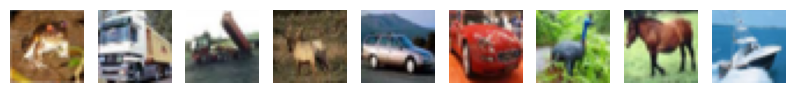

In [6]:
# Displaying the images in the dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(5, 9, i + 1)
    plt.imshow(training_dataset[i])
    plt.axis('off')

plt.show()

As we can see, the images are quite small and have low resolution. The dataset contains a variety of objects, such as animals, vehicles, and other everyday items. The images are in color and have a resolution of 32x32 pixels. The next step is to preprocess the data before building the model.

### 2.2 Preprocessing the Data

Before we can move onto building the model, we will split the data into training and validation sets, preprocess the images, and one-hot encode the labels. We will also normalize the pixel values to be in the range [0, 1] by dividing by 255.

In [7]:
# Splitting the data into training and validation sets
inputs_train, inputs_val, targets_train, targets_val = train_test_split(training_dataset, training_labels,
                                                                        test_size=0.2, random_state=42)

The training set has been successfully split into training and validation sets. Let's check the shape of the training and validation sets.

In [8]:
# Displaying the shape of the training and validation sets
inputs_train.shape, inputs_val.shape, targets_train.shape, targets_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

The training set contains 40,000 images, while the validation set contains 10,000 images. We can now move onto bulding the model.

## 3. Building the Model

In this section, we will build the model by selecting a pretrained convolutional base and constructing a fully connected classifier. We will then compile the model and train it on the CIFAR-10 dataset. For this notebook, we will use the VGG16 model as the convolutional base, and add a fully connected classifier on top of it.

### 3.1 Loading the Pretrained Convolutional Base

Next we will load the VGG16 model as the convolutional base.

In [9]:
# Loading the VGG16 model as the convolutional base
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freezing the convolutional base
conv_base.trainable = False

I0000 00:00:1731461172.457947   71942 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731461172.520972   71942 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731461172.521053   71942 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731461172.538332   71942 service.cc:146] XLA service 0x126fc40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731461172.538371   71942 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1731461172.764690   72078 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/num

The VGG16 model has been successfully loaded as the convolutional base. Let's check the summary of the model.

In [10]:
# Displaying the summary of the VGG16 model
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

The VGG16 model has a total of 14,714,688 parameters. The convolutional base consists of 13 convolutional layers and 3 dense layers. 

### 3.1 Extracting Features from the Convolutional Base

Before we compile and train the model, we need to extract features from the convolutional base. We will preprocess the images and one-hot encode the labels before extracting the features using the `conv_base.predict()` function.

In [11]:
# Preprocessing the images and one-hot encoding the labels
def get_features_and_targets(images, labels):
    preprocess_images = preprocess_input(images)
    features = conv_base.predict(preprocess_images, batch_size=32, verbose=0)
    return features, to_categorical(labels)


train_features, train_labels = get_features_and_targets(inputs_train, targets_train)
val_features, val_labels = get_features_and_targets(inputs_val, targets_val)
test_features, test_labels = get_features_and_targets(testing_dataset, testing_labels)

I0000 00:00:1731461176.399739   72082 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


The features have been successfully extracted from the convolutional base. Let's check the shape of the training, validation, and testing features.

In [12]:
# Displaying the shape of the training, validation, and testing features
train_features.shape, val_features.shape, test_features.shape

((40000, 1, 1, 512), (10000, 1, 1, 512), (10000, 1, 1, 512))

The training features have a shape of (40,000, 1, 1, 512), the validation features have a shape of (10,000, 1, 1, 512), and the testing features have a shape of (10,000, 1, 1, 512). Let's also check the shape of the training, validation, and testing labels.

In [13]:
# Displaying the shape of the training, validation, and testing labels
train_labels.shape, val_labels.shape, test_labels.shape

((40000, 10), (10000, 10), (10000, 10))

The training, validation, and testing labels have been successfully one-hot encoded. The next step is to compile and train the model.

In [14]:
# Building the model
inputs = Input(shape=(1, 1, 512))
x = Flatten()(inputs)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

The model has been successfully built. Let's check the summary of the model.

In [15]:
# Displaying the summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,786 (1.02 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

The model has a total of 267,786 parameters. The model consists of a Flatten layer, a Dropout layer, a Dense layer with 512 units and ReLU activation, and a Dense layer with 10 units and softmax activation.

## 4. Compiling and Fitting the Model

In this section, we will compile the model and train it on the CIFAR-10 dataset. We will use the Adam optimizer, categorical crossentropy as the loss function, and accuracy as the evaluation metric. We will also incorporate data augmentation to enhance the model's performance.

We will also save the best version of the model based on the validation loss using the `ModelCheckpoint` callback.

In [16]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Creating the ModelCheckpoint callback
callbacks = [
    ModelCheckpoint(filepath="../../Models/cifar-10_vgg16.keras", save_best_only=True, monitor="val_loss")
]

# Fitting the model
history = model.fit(train_features, train_labels, epochs=30, batch_size=16, validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5298 - loss: 3.6703 - val_accuracy: 0.6091 - val_loss: 1.5495
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6668 - loss: 1.3435 - val_accuracy: 0.6377 - val_loss: 1.4408
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6708 - loss: 1.2869 - val_accuracy: 0.6445 - val_loss: 1.3576
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6904 - loss: 1.2067 - val_accuracy: 0.6414 - val_loss: 1.3889
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6992 - loss: 1.1670 - val_accuracy: 0.6414 - val_loss: 1.3749
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7049 - loss: 1.1279 - val_accuracy: 0.6457 - val_loss: 1.3607
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7208 - loss: 1.0865 - val_accuracy: 0.6413 - val_loss: 1.3575
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7240 - loss: 1.0558 - 

The model has been successfully compiled and trained. We can now move onto evaluating the model.

## 5. Evaluating the Model

In this section, we will evaluate the model on the testing dataset and visualize the training and validation loss and accuracy. 

### 5.1 Evaluating the Model on the Testing Dataset

Let's evaluate the model on the testing dataset and calculate the test accuracy.

In [24]:
# Evaluating the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

# Displaying the test accuracy
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6376 - loss: 1.4583
Test accuracy: 63.72%


The model achieved an accuracy of 63.72% on the testing dataset. Next, we will visualize the training and validation loss and accuracy.

### 5.2 Visualizing the Training and Validation Loss and Accuracy

Let's visualize the training and validation loss and accuracy to understand the model's performance.

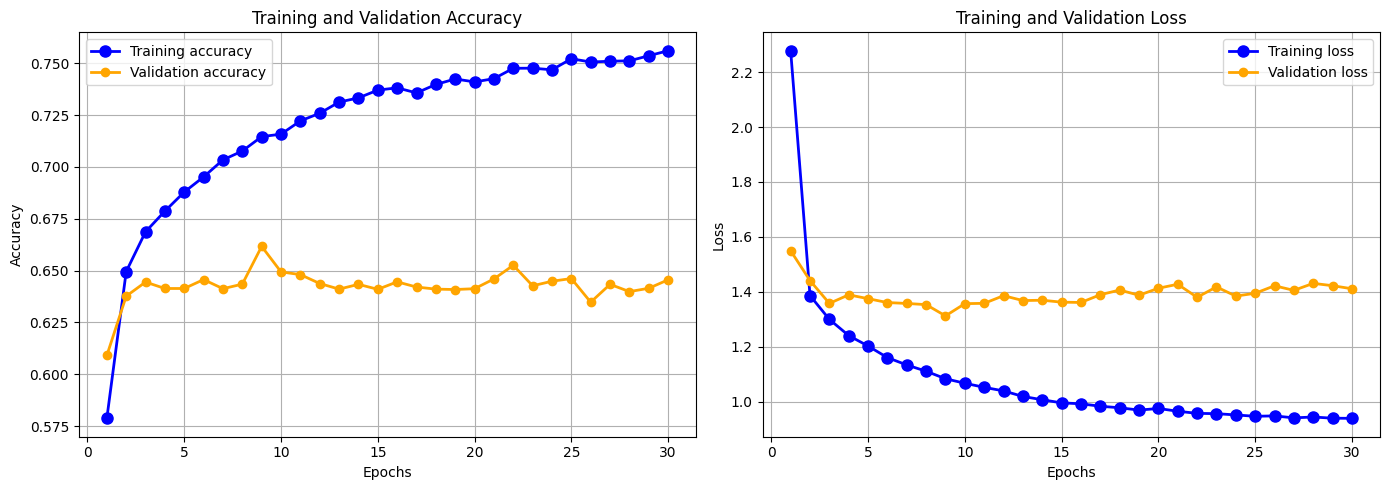

In [25]:
# Extracting data from the new model's history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy on the first subplot (left) with blue and orange colors
ax1.plot(epochs, accuracy, marker="o", linestyle="-", label="Training accuracy", markersize=8, linewidth=2, color="blue")
ax1.plot(epochs, val_accuracy, marker="o", linestyle="-", label="Validation accuracy", linewidth=2, color="orange")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Plot loss on the second subplot (right) with blue and orange colors
ax2.plot(epochs, loss, marker="o", linestyle="-", label="Training loss", markersize=8, linewidth=2, color="blue")
ax2.plot(epochs, val_loss, marker="o", linestyle="-", label="Validation loss", linewidth=2, color="orange")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

The model achieved a training accuracy of about 75% and a validation accuracy of around 65% after 30 epochs. The training loss showed a steady decline, indicating that the model continued learning from the training data. However, the validation accuracy remained relatively flat, and the validation loss fluctuated, suggesting the model struggled to generalize effectively to the validation set and may be overfitting.

## 6. Conclusion

In this notebook, we successfully built a model for image classification using a pretrained convolutional base and a fully connected classifier. We trained the model on the CIFAR-10 dataset and evaluated its performance on the testing dataset. The model achieved an accuracy of 63.72% on the testing dataset.

We also visualized the training and validation loss and accuracy to understand the model's performance. The training accuracy reached approximately 75%, while the validation accuracy plateaued around 65%. The training loss consistently decreased, indicating that the model effectively learned from the training data.

Overall, the model performed reasonably well on the CIFAR-10 dataset. However, there is room for improvement in terms of generalization performance and accuracy. In future work, we could explore additional techniques such as hyperparameter tuning, model architecture modifications, and advanced regularization methods to enhance the model's performance further.